## Partie I: Preparation des données (preprocessing)

In [34]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from io import BytesIO #permet de stocker en mémoire
from zipfile import ZipFile

url2019 = "https://www.insee.fr/fr/statistiques/fichier/4809583/fd_eec19_csv.zip" #enquete 2019
url2020="https://www.insee.fr/fr/statistiques/fichier/5393560/fd_eec20_csv.zip" #enquête 2020 en exemple

# Télécharge le fichier ZIP
requete = requests.get(url2019)
zip_df = ZipFile(BytesIO(requete.content)) #créer un fichier ZIP

# Extraire le fichier CSV du ZIP
with zip_df.open(zip_df.namelist()[0]) as extrait:
    EEC_2019 = pd.read_csv(extrait, delimiter=";") # Lire le fichier CSV avec pandas

# Télécharge le fichier ZIP
requete = requests.get(url2020)
zip_df = ZipFile(BytesIO(requete.content)) #créer un fichier ZIP

# Extraire le fichier CSV du ZIP
with zip_df.open(zip_df.namelist()[0]) as extrait:
    EEC_2020 = pd.read_csv(extrait, delimiter=";") # Lire le fichier CSV avec pandas

In [35]:
# On choisit un set de features qui ne comprend que données sociodémographiques, géographiques associées à l'individu
# et au ménage étudié + qui sont disponibles sur les deux années étudiées

# label -> ACTEU

# features à inclure dans le modèle -> AGE3 ;  AGE5 ; ANNEE ;TRIM ;  CATAU2010R ; COURED ; CSTOT (pour avoir actifs et inactifs) ;CSTOTR ;
# CSTOTPRM ; DIP11; ENFRED ; METRODOM ; NFRRED ; SEXE ; TYPMEN7 

# USE? -> AIDFAM , CHPUB?? (Employeur de la profession principale?), EXTRIAN? (pondération)

# Meme si les variables sont colinéaires (AGE3, AGE5), on peut les garder et faire en sorte que le predicteur
# choisisse la plus pertinente

# Je pense que le problème principal vient du fait qu'on a en fait trop peu de variable, et donc rien qui ne puisse être vraiment pertinent en fait
#c'est pour cela que les algorithmes ne trouvent rien je pense. (Alexis)

list_var_selected = ["ACTEU","ANNEE" ,"TRIM", "AGE3" ,  "AGE5"  , "CATAU2010R" ,
"COURED" ,"CSTOT" ,"CSTOTR" ,"CSTOTPRM" , "DIP11","ENFRED" , "METRODOM" , "NFRRED" , "SEXE" , "TYPMEN7"]

EEC_2019 = EEC_2019[list_var_selected]
EEC_2020 = EEC_2020[list_var_selected]

list_var = list(EEC_2019.columns.values)
print(list_var)

#je regarde ce qu'il se passe si je ne sépare pas les trimestres, le prof avait l'air de dire que c'était pas forcément grave (Alexis)
#EEC_2019 = EEC_2019[EEC_2019['TRIM'] ==1]
#EEC_2020 = EEC_2020[EEC_2020['TRIM'] ==4]

# Il y a très peu de valeurs manquantes dans les variables ->  dropna() drops any row that contains at least one missing value
# On aurait aussi pu faire de l'imputation
print(EEC_2019.shape)
EEC_2019 = EEC_2019.dropna() 
EEC_2020 = EEC_2020.dropna() 
print(EEC_2019.shape)

# Converti l'ensemble des variables catégorielles en dummies
# Oui oui faut le faire, par contre pour les variables qui sont DEJA des dummies, c'est pas la peine, faut juste les recoder en 0 et 1
EEC_2019 = pd.get_dummies(EEC_2019, columns=["AGE3" ,  "AGE5"  , "CATAU2010R" ,
"CSTOT" ,"CSTOTR" ,"CSTOTPRM" , "DIP11", "NFRRED" , "TYPMEN7"])
EEC_2020 = pd.get_dummies(EEC_2020, columns=["AGE3" ,  "AGE5"  , "CATAU2010R" ,
"CSTOT" ,"CSTOTR" ,"CSTOTPRM" , "DIP11", "NFRRED" , "TYPMEN7"])

#RECODAGE variables binaires (dummies)

EEC_2019['EMPLOI'] = EEC_2019['ACTEU'].apply(lambda x: x == 1)
EEC_2020['EMPLOI'] = EEC_2020['ACTEU'].apply(lambda x: x == 1)


EEC_2019['FEMME'] = EEC_2019['SEXE'].apply(lambda x: x == 2)
EEC_2020['FEMME'] = EEC_2020['SEXE'].apply(lambda x: x == 2)

EEC_2019['COUPLE'] = EEC_2019['COURED'].apply(lambda x: x == 2)
EEC_2020['COUPLE'] = EEC_2020['COURED'].apply(lambda x: x == 2)

EEC_2019['ENFANT'] = EEC_2019['ENFRED'].apply(lambda x: x == 2)
EEC_2020['ENFANT'] = EEC_2020['ENFRED'].apply(lambda x: x == 2)


EEC_2019['DOM'] = EEC_2019['METRODOM'].apply(lambda x: x == 2)
EEC_2020['DOM'] = EEC_2020['METRODOM'].apply(lambda x: x == 2)

#Vire les anciennes
EEC_2019 = EEC_2019.drop(['METRODOM', 'ENFRED' , 'COURED', 'SEXE',"ACTEU"], axis=1)
EEC_2020 = EEC_2020.drop(['METRODOM', 'ENFRED' , 'COURED', 'SEXE',"ACTEU"], axis=1)

# 133 variables
print(EEC_2019.shape)

# Gestion des outliers??? Pas nécessaire ici puisqu'on fonctionne seulement avec des variables catégorielles

# standardisation des variables explicatives ? Pas utile car que des dummies
# (La standardisation permet une convergence plus rapide des algorithmes pour des variables réelles)

EEC_2019_subsample = EEC_2019.sample(n=100000, random_state=3) 


['ACTEU', 'ANNEE', 'TRIM', 'AGE3', 'AGE5', 'CATAU2010R', 'COURED', 'CSTOT', 'CSTOTR', 'CSTOTPRM', 'DIP11', 'ENFRED', 'METRODOM', 'NFRRED', 'SEXE', 'TYPMEN7']
(416298, 16)
(412028, 16)
(412028, 133)


In [3]:
# Balanced sample avec prediction emploi
proportion_values = EEC_2019_subsample['EMPLOI'].value_counts(normalize=True)
print(proportion_values)

EMPLOI
False    0.5292
True     0.4708
Name: proportion, dtype: float64


In [4]:
# Description d'une feature pour check booléen
variable_description = EEC_2019_subsample["FEMME"].describe()

print(variable_description)

count     10000
unique        2
top        True
freq       5188
Name: FEMME, dtype: object


In [50]:
# On transforme nos dataframes en array car sklearn est bien adapté pour travailler sur ce type de données

# Array contentant l'ensemble des variables explicatives (on exclut donc CHOMAGE/ANNEE/TRIM)
X = np.array(EEC_2019_subsample.drop(columns=["EMPLOI","ANNEE", "TRIM"]))
print(X.shape)

# Array contentant la variable expliquée
y = np.array(EEC_2019_subsample["EMPLOI"])
print(y.shape)


print(X[:10])
print(y[:10])


(100000, 130)
(100000,)
        ANNEE  TRIM  AGE3_15  AGE3_30  AGE3_50  AGE5_15  AGE5_30  AGE5_40  \
209982   2019     3    False    False     True    False    False    False   
103214   2019     1    False    False     True    False    False    False   
100754   2019     2    False    False     True    False    False    False   
9980     2019     1    False    False     True    False    False    False   
233690   2019     1    False    False     True    False    False    False   
204343   2019     2    False    False     True    False    False    False   
150837   2019     3     True    False    False     True    False    False   
266463   2019     3    False    False     True    False    False    False   
406751   2019     1    False    False     True    False    False    False   
261539   2019     1    False    False     True    False    False    False   

        AGE5_50  AGE5_60  ...  TYPMEN7_3  TYPMEN7_4  TYPMEN7_5  TYPMEN7_6  \
209982    False     True  ...      False      False

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.2, random_state=3)

## Partie II : Support Vector Machine

In [7]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score


acc_train, acc_test = list(), list()
f1_train, f1_test = [], []

C_range = np.linspace(0.1, 20, 50)
for param in C_range:
    clf = SVC( C=param, random_state=3)
    clf.fit(X_train, y_train)
    acc_train.append(clf.score(X_train, y_train))
    acc_test.append(clf.score(X_test, y_test))
    
    y_pred_train = clf.predict(X_train)
    f1_train.append(f1_score(y_train, y_pred_train, average='binary'))  
    
    y_pred_test = clf.predict(X_test)
    f1_test.append(f1_score(y_test, y_pred_test, average='binary'))


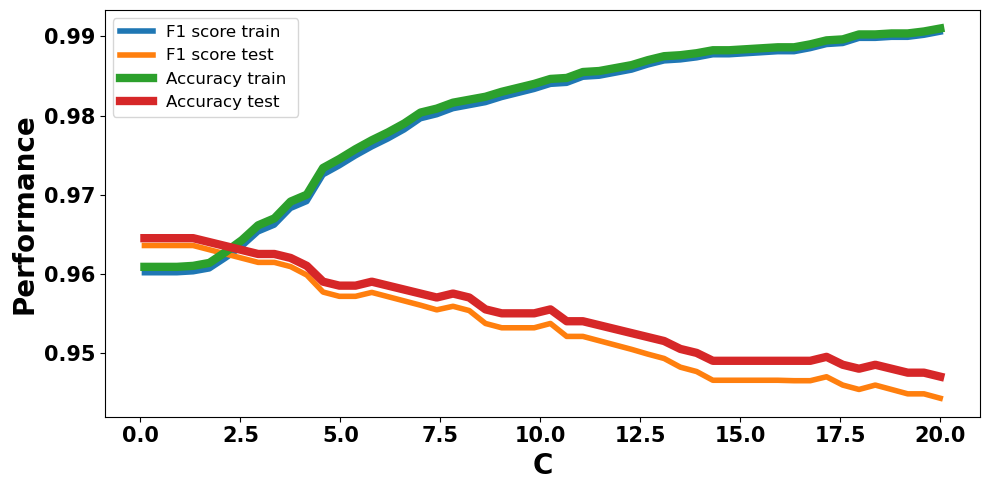

In [8]:
plt.figure(figsize=(10, 5))

plt.plot(C_range, f1_train, label='F1 score train', lw=6)
plt.plot(C_range, f1_test, label='F1 score test', lw=6)

plt.plot(C_range, acc_train, label='Accuracy train ', lw=6)
plt.plot(C_range, acc_test, label='Accuracy test', lw=6)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()


In [9]:
from sklearn.model_selection import GridSearchCV

params= { 'C':np.linspace(0.001, 5, 50) }
gs = GridSearchCV(estimator=SVC( C=params, random_state=3), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)

#Calcule accuracy du meilleur model trouvé par grid search sur le sample choisi
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

{'C': 0.041775510204081635}
0.960875
0.9645


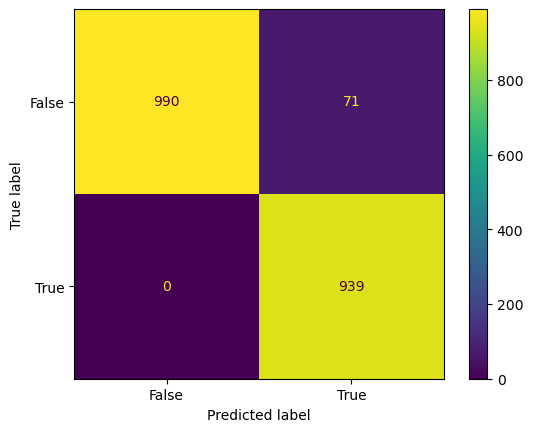

In [12]:
clf = SVC( C=gs.best_params_['C'], random_state=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


cm= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

In [13]:
misclassified_indices = np.where(y_test != y_pred)[0]

# XX personnes préditent comme des actifs occupés alors qu'ils sont inactifs/chomeurs
# 0 personnes préditent pas actif occupés alors qu'ils le sont
print(y_test[misclassified_indices])

# ATTENTION -> Regarder si ils sont chomeurs ou inactifs?

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False]


## Partie III - Regression logistique

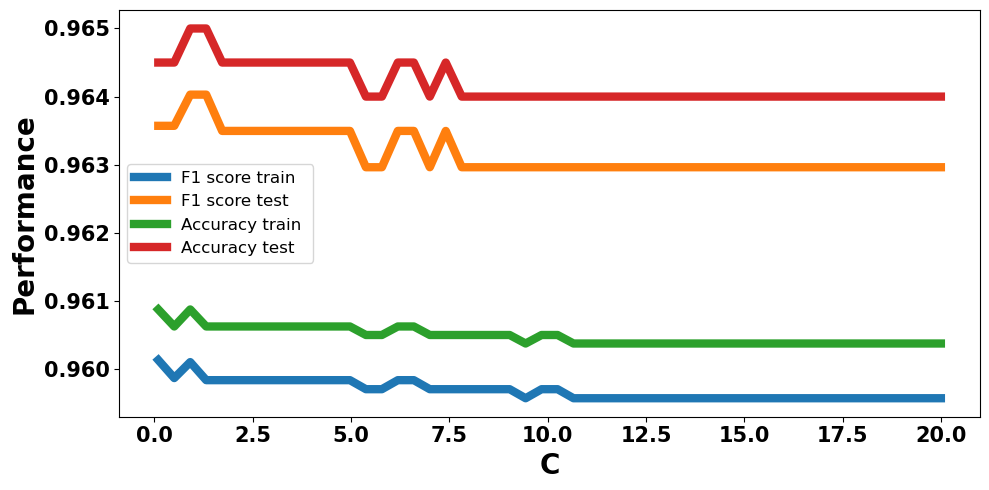

In [20]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

acc_train, acc_test = list(), list()
f1_train, f1_test = [], []

                        
C_range = np.linspace(0.1, 20, 50)

for param in C_range:
    clf = LogisticRegression(C=param,random_state=3, penalty="l1",solver='liblinear' )
    clf.fit(X_train, y_train)
    acc_train.append(clf.score(X_train, y_train))
    acc_test.append(clf.score(X_test, y_test))
    
    y_pred_train = clf.predict(X_train)
    f1_train.append(f1_score(y_train, y_pred_train, average='binary'))  
    
    y_pred_test = clf.predict(X_test)
    f1_test.append(f1_score(y_test, y_pred_test, average='binary'))
    
plt.figure(figsize=(10, 5))

plt.plot(C_range, f1_train, label='F1 score train', lw=6)
plt.plot(C_range, f1_test, label='F1 score test', lw=6)

plt.plot(C_range, acc_train, label='Accuracy train ', lw=6)
plt.plot(C_range, acc_test, label='Accuracy test', lw=6)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()


In [22]:
# Processus de cross-validation qui découpe notre échantillon en 5 et détermine le paramètre de régularisation optimal
# ATTENTION -> gain de selection des paramètres via cross validation est marginal par rapport à la selection des bonnes variables 
# On utilise GridSearch ici parce qu'on veut combiner plusieurs paramètres

#  By default, scikit-learn's GridSearchCV does not select the most parsimonious model (fewer features)
# when multiple models have equal scores. GridSearchCV uses the mean cross-validated score to select
# the best model based on the specified scoring metric.
# If there are multiple models with the same highest mean score, GridSearchCV selects
# the one with the smallest value of the parameters.

# If we want to select the most parsimonious model among those with equal scores,
# you may need to implement a custom scoring function

params= { 'C':np.linspace(0.001, 5, 50) }
gs = GridSearchCV(estimator=LogisticRegression(random_state=3, penalty ="l1",  solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)

results_df = pd.DataFrame(gs.cv_results_)
print(results_df[['params', 'mean_test_score', 'std_test_score']])

                       params  mean_test_score  std_test_score
0                {'C': 0.001}         0.528875        0.000250
1   {'C': 0.1030204081632653}         0.960875        0.002550
2   {'C': 0.2050408163265306}         0.960875        0.002550
3   {'C': 0.3070612244897959}         0.960750        0.002417
4   {'C': 0.4090816326530612}         0.960625        0.002305
5   {'C': 0.5111020408163265}         0.960625        0.002305
6   {'C': 0.6131224489795918}         0.960250        0.002756
7   {'C': 0.7151428571428571}         0.960250        0.002756
8   {'C': 0.8171632653061224}         0.960000        0.003236
9   {'C': 0.9191836734693877}         0.959875        0.003478
10  {'C': 1.0212040816326529}         0.959875        0.003478
11   {'C': 1.123224489795918}         0.959875        0.003478
12  {'C': 1.2252448979591835}         0.959875        0.003478
13  {'C': 1.3272653061224489}         0.959875        0.003478
14   {'C': 1.429285714285714}         0.959875        0

In [23]:
# On refait meme process en jouant en + sur le critère de penalty et le tol
# tol = tolerance for stopping criteria. It defines the stopping criterion for the solver to converge to a solution.

params= { 'C':np.linspace(0.001, 5, 50),'tol': [0.01, 0.1, 1, 10] }


gs = GridSearchCV(estimator=LogisticRegression(random_state=3, penalty ="l1",  solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)

# calcule accuracy du meilleur model trouvé par grid search sur le sample choisi
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

{'C': 0.1030204081632653, 'tol': 0.01}
0.960875
0.9645


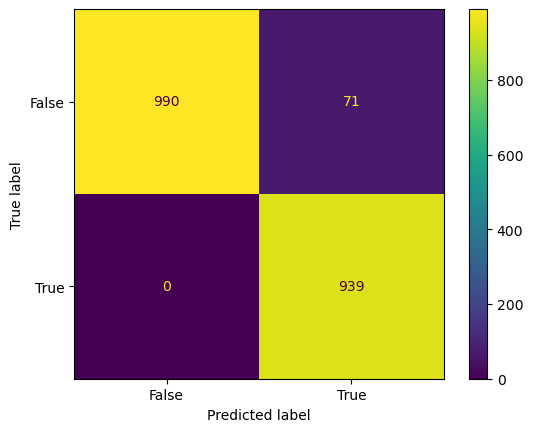

In [24]:
clf = LogisticRegression( tol=gs.best_params_['tol'], C=gs.best_params_['C'], random_state=3,
                         penalty ="l1", solver='liblinear')

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


cm= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

In [25]:
num_variables = np.sum(np.abs(clf.coef_) > 1e-10)
print("Number of variables considered:", num_variables)

Number of variables considered: 21


## Partie IV : Selections de variables

In [75]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

#  Lasso linear model with cross-validated selection of the regularization parameter (alpha) to find the optimal
clf = LassoCV()
clf.fit(X, y)

# Je m'impose un maximum de 10 features selectionnées
sfm = SelectFromModel(clf, prefit=False, max_features=10)

sfm.fit(X,y)
X_transform = sfm.transform(X)
print("Transformed data shape:", X_transform.shape)
print("Original data shape:", X.shape)

KeyboardInterrupt: 

In [ ]:
from sklearn.linear_model import LogisticRegression

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_transform, 
                                                    y, 
                                                    test_size=.2, random_state=3)


params= { 'C':np.linspace(0.001, 1, 50), 'tol': [0.01, 0.1, 1, 10] }



gs = GridSearchCV(estimator=LogisticRegression( random_state=3, penalty = "l1", solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train_2, y_train_2)

print(gs.best_params_)
print(gs.score(X_train_2, y_train_2))
print(gs.score(X_test_2, y_test_2))

Number of variables considered: 3


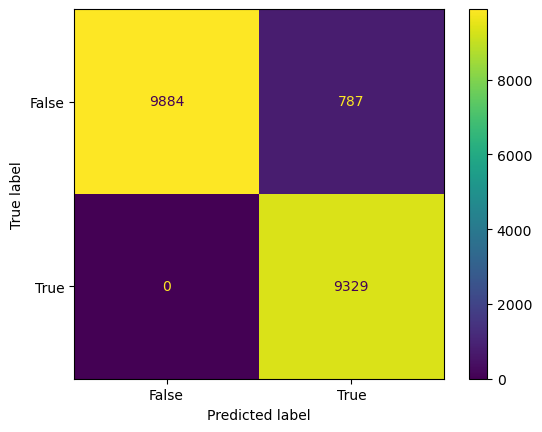

In [76]:
clf = LogisticRegression(tol=gs.best_params_['tol'], C=gs.best_params_['C'],
                         random_state=3, penalty="l1", solver='liblinear')

clf.fit(X_train_2, y_train_2)
y_pred_2 = clf.predict(X_test_2)

cm= confusion_matrix(y_test_2, y_pred_2)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

num_variables = np.sum(np.abs(clf.coef_) > 1e-10)
print("Number of variables considered:", num_variables)

#On obtient la meme matrice en utilisant ici que 3 variables explicatives

In [80]:
variables_indices = np.where(np.abs(clf.coef_) > 1e-10)[1]
variables = EEC_2019_subsample.drop(columns=["EMPLOI", "ANNEE", "TRIM"]).columns[variables_indices].values
print(variables_indices)
print(variables)

# predicteur efficace avec 3 variables : avoir la cinquantaine, la soixantaine, habiter une grande aire urbaine


[6 7 8]
['AGE5_50' 'AGE5_60' 'CATAU2010R_1']


(100000, 3)
Number of variables considered: 3


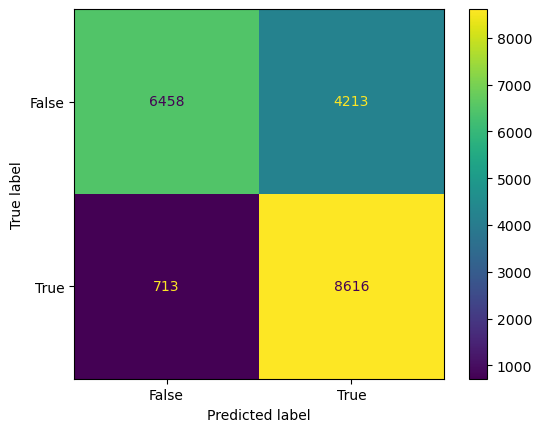

In [86]:
X_bis = np.array(EEC_2019_subsample.loc[:,variables])

print(X_bis.shape)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_bis, 
                                                    y, 
                                                    test_size=.2, random_state=3)

clf = LogisticRegression(random_state=3, penalty="l1", solver='liblinear')

clf.fit(X_train_3, y_train_3)
y_pred_3 = clf.predict(X_test_3)

cm= confusion_matrix( y_test_3,y_pred_3)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

num_variables = np.sum(np.abs(clf.coef_) > 1e-10)
print("Number of variables considered:", num_variables)


#Pq je retrouve pas le meme score/ meme matrice de confusion alors que je reprends les meme variables???